
# 🧠 First Principles Walkthrough: Training a LoRA Adapter on SDXL

This notebook walks through the entire process of training a Low-Rank Adaptation (LoRA) adapter on Stable Diffusion XL (SDXL), starting from first principles.

We'll cover:

1. What is Stable Diffusion XL?
2. What is LoRA and why use it?
3. Data preprocessing and dual-text encoder design
4. Modifying UNet with LoRA (PEFT)
5. The diffusion process and noise prediction training loop
6. Saving in `.safetensors` format
7. Inference with trained weights
8. Visualization and debugging

---



## 📌 1. What is Stable Diffusion XL (SDXL)?

SDXL is a state-of-the-art text-to-image generation model. It consists of:

- A **Variational Autoencoder (VAE)** to encode/decode images into/from latent space.
- A **UNet** that predicts noise added to the latent image.
- A **dual-text encoder system** (CLIP ViT-L and ViT-G) that extracts conditioning from the prompt.
- A **scheduler** to model the denoising steps during diffusion.

In training, the goal is to **learn a network that can predict the noise added to an image** in latent space, conditioned on text.



## 🔧 2. What is LoRA?

**LoRA** (Low-Rank Adaptation) reduces training cost by freezing the base model and injecting small trainable matrices into the attention projections.

Instead of training all weights in a model like UNet, LoRA trains only rank-decomposed updates (matrices `A` and `B`) inserted into key layers.

Benefits:
- 🚀 Requires much less VRAM and training time.
- 🔌 Easy to plug into pre-trained models.
- 🧠 Maintains generalization while specializing to specific domains (e.g. faces, clothes).

We'll apply LoRA to specific layers of the SDXL UNet attention modules.



## 🖼️ 3. Dataset Loading and Dual Tokenization

We load images and pair them with text captions. Each caption is tokenized twice:

- Once using **CLIP ViT-L/14** (text_encoder)
- Once using **CLIP ViT-G/14** (text_encoder_2)

These dual embeddings are concatenated and passed as the condition to the UNet.


In [ ]:

from transformers import CLIPTokenizer
tokenizer_1 = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="tokenizer")
tokenizer_2 = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="tokenizer_2")

caption = "a fantasy castle on a cliff during sunset"
tokens_1 = tokenizer_1(caption, return_tensors="pt")
tokens_2 = tokenizer_2(caption, return_tensors="pt")
tokens_1.input_ids.shape, tokens_2.input_ids.shape



## 🧠 4. Injecting LoRA into UNet

We wrap the UNet using `peft` to insert trainable matrices into its attention projections.

Target layers:
- `to_q`, `to_k`, `to_v`, and `to_out.0` (attention layers in SDXL UNet)


In [ ]:

from diffusers import UNet2DConditionModel
from peft import LoraConfig, get_peft_model

unet = UNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="unet")
config = LoraConfig(
    r=4, lora_alpha=32, lora_dropout=0.05,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    bias="none"
)
unet = get_peft_model(unet, config)



## 🌫️ 5. Diffusion Process: Noise Prediction

Training teaches UNet to reverse a diffusion process that gradually adds noise to images.

Steps:

1. Encode image → latent space with VAE
2. Add noise to the latent
3. UNet tries to predict the noise added
4. Loss is MSE between predicted and actual noise


In [ ]:

# Assume latent, noise, and text conditions are ready
pred = unet(latent_model_input, timesteps, encoder_hidden_states=hidden_states).sample
loss = torch.nn.functional.mse_loss(pred.float(), noise.float())
loss.backward()
optimizer.step()



## 💾 6. Saving Weights in `.safetensors`

Instead of saving full model weights, we only save the LoRA adapter matrices A and B.


In [ ]:

from safetensors.torch import save_file
def save_lora(unet, path):
    lora_dict = {}
    for name, module in unet.named_modules():
        if hasattr(module, "lora_A") and hasattr(module, "lora_B"):
            lora_dict[f"{name}.lora_A.weight"] = module.lora_A.weight
            lora_dict[f"{name}.lora_B.weight"] = module.lora_B.weight
    save_file(lora_dict, path)



## 🔍 7. Inference with Trained Weights

We use the base SDXL pipeline with LoRA weights injected into the UNet.


In [ ]:

from diffusers import StableDiffusionXLPipeline

pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16).to("cuda")
pipe.unet = get_peft_model(pipe.unet, config)
pipe.unet.load_state_dict(torch.load("lora_weights/lora_output.safetensors"), strict=False)

image = pipe(prompt="a girl in cyber armor").images[0]
image.show()



## 📈 8. Visualizing Loss

If you log loss values during training, you can visualize them to track learning dynamics.


In [ ]:

import matplotlib.pyplot as plt

losses = [0.25, 0.21, 0.18, 0.16, 0.14, 0.13]
plt.plot(losses)
plt.title("Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



## 🔍 9. Latent Space, Encoding & Decoding

SDXL does **not** operate on pixels directly — instead, it uses a **Variational Autoencoder (VAE)** to compress images into a smaller latent space.

### ➕ Encoding
The encoder `E(x)` maps an image `x` (e.g., 512x512x3) into a latent tensor `z` (e.g., 64x64x4).

$$
z = E(x)
$$

### ➖ Decoding
The decoder `D(z)` reconstructs the image:

$$
\hat{x} = D(z)
$$

This compression improves training and inference speed and enables image generation from the latent domain.



## 📐 10. What Are Schedulers in Diffusion?

Schedulers define how noise is added to latents and later removed.

Given a latent `z_0`, we simulate a noisy latent `z_t` by:

$$
z_t = \sqrt{\alpha_t} z_0 + \sqrt{1 - \alpha_t} \epsilon
$$

Where:
- `α_t` is the noise level at timestep `t`
- `ε` is random Gaussian noise

During training, the UNet learns to predict `ε`.



## 🧾 11. Text Encoding: CLIP in SDXL

Text prompts are converted into conditioning vectors using **CLIP encoders**:

- `text_encoder` → CLIP ViT-L/14 (larger embedding)
- `text_encoder_2` → CLIP ViT-G/14 (pooled global features)

These are concatenated and given to UNet as `encoder_hidden_states` and `added_cond_kwargs`.

### CLIP Output:
- `last_hidden_state` (sequence of token embeddings)
- `pooler_output` (sentence-level embedding)



## 🧠 12. What Are Attention Projections?

Attention in transformers involves computing:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

Where:

- `Q = W_q x` → **query**
- `K = W_k x` → **key**
- `V = W_v x` → **value**
- `W_out` projects the output

In SDXL UNet, these correspond to:

- `to_q`: linear layer for queries
- `to_k`: keys
- `to_v`: values
- `to_out.0`: final linear projection after attention output

LoRA injects trainable low-rank matrices into these `W_q, W_k, W_v, W_out` projections.



## 🎯 13. Noise Prediction Objective

At training step `t`, the model sees:

- Noisy latent: `z_t`
- Text conditioning: `c`
- Timestep `t`

It tries to predict the original noise `ε`:

$$
\hat{\epsilon} = UNet(z_t, t, c)
$$

The loss is Mean Squared Error:

$$
\mathcal{L} = \mathbb{E}[||\epsilon - \hat{\epsilon}||^2]
$$

This teaches UNet to reverse the diffusion process.



## 🚀 14. Inference with LoRA

At inference time:

1. We start with pure noise: `z_T ~ N(0, I)`
2. Iteratively denoise it using the **UNet + LoRA**
3. Decode final `z_0` using the VAE

Each denoising step applies the text-conditioned UNet with LoRA layers active:

$$
z_{t-1} = \text{scheduler.step}(UNet(z_t, t, c), t, z_t)
$$

This loop runs from `T` to `0`, producing a latent which is then decoded into an image.



## 🎬 15. Full Animated Pipeline

This animation walks through the SDXL LoRA training pipeline step-by-step, revealing each component and connection in order.


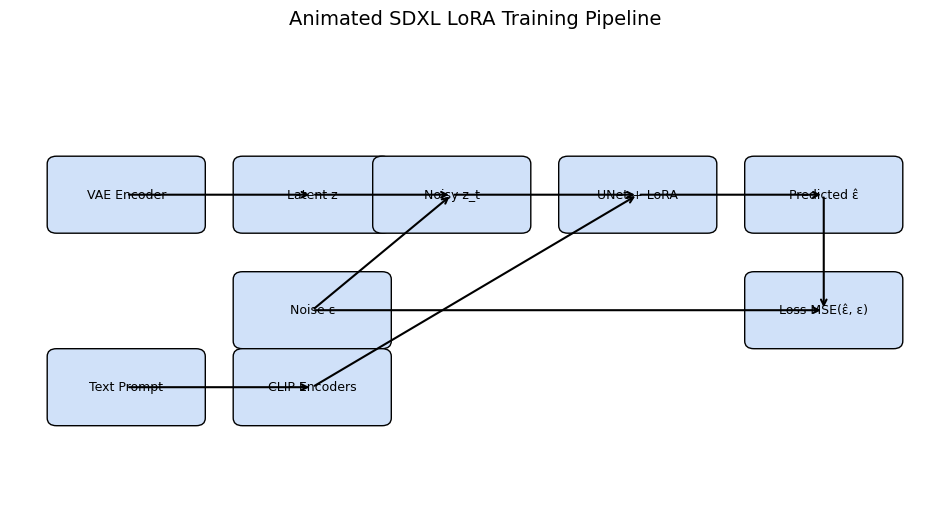

In [2]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

components = {
    "VAE Encoder": (0.5, 3.5),
    "Latent z": (2.5, 3.5),
    "Noise ε": (2.5, 2.0),
    "Noisy z_t": (4.0, 3.5),
    "Text Prompt": (0.5, 1.0),
    "CLIP Encoders": (2.5, 1.0),
    "UNet + LoRA": (6.0, 3.5),
    "Predicted ε̂": (8.0, 3.5),
    "Loss MSE(ε̂, ε)": (8.0, 2.0),
}

arrows = [
    ("VAE Encoder", "Latent z"),
    ("Latent z", "Noisy z_t"),
    ("Noise ε", "Noisy z_t"),
    ("Text Prompt", "CLIP Encoders"),
    ("CLIP Encoders", "UNet + LoRA"),
    ("Noisy z_t", "UNet + LoRA"),
    ("UNet + LoRA", "Predicted ε̂"),
    ("Predicted ε̂", "Loss MSE(ε̂, ε)"),
    ("Noise ε", "Loss MSE(ε̂, ε)"),
]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis("off")
ax.set_title("Animated SDXL LoRA Training Pipeline", fontsize=14)

boxes = {}
texts = {}
for label, (x, y) in components.items():
    box = patches.FancyBboxPatch((x, y), 1.5, 0.8, boxstyle="round,pad=0.1", edgecolor="black", facecolor="#d0e1f9", visible=False)
    txt = ax.text(x + 0.75, y + 0.4, label, ha="center", va="center", fontsize=9, visible=False)
    ax.add_patch(box)
    boxes[label] = box
    texts[label] = txt

arrow_lines = []

def animate(i):
    if i < len(components):
        label = list(components.keys())[i]
        boxes[label].set_visible(True)
        texts[label].set_visible(True)
    elif i - len(components) < len(arrows):
        src, dst = arrows[i - len(components)]
        pos = {label: (x+0.75, y+0.4) for label, (x, y) in components.items()}
        line = ax.annotate("", xy=pos[dst], xytext=pos[src],
                           arrowprops=dict(arrowstyle="->", lw=1.5))
        arrow_lines.append(line)
    return list(boxes.values()) + list(texts.values()) + arrow_lines

ani = animation.FuncAnimation(fig, animate, frames=len(components)+len(arrows), interval=800, blit=False)

from IPython.display import HTML
HTML(ani.to_jshtml())



## 🎞️ 16. Animation Hooks

For animations, we can visualize the diffusion process step-by-step using matplotlib.

This simulates how a pure noise latent evolves into a generated image during inference.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Simulate a noise to image transition (example)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(np.random.randn(64, 64), cmap="gray", vmin=-3, vmax=3)
ax.set_title("Diffusion Steps")
ax.axis("off")

def update(i):
    np.random.seed(i)
    alpha = 1 - (i / 20)
    frame = alpha * np.random.randn(64, 64)
    im.set_data(frame)
    ax.set_title(f"Step {i}")
    return [im]

ani = animation.FuncAnimation(fig, update, frames=20, interval=300, blit=True)
plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())
